In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import exp1

import viz 
# use the style file
plt.style.use('style.mpl')

colors = viz.color_palette()

In [2]:
class PowerLawSimulation:
    def __init__(self, t_min, t_max):
        self.t_min = t_min
        self.t_max = t_max

        self.g_ts = None
        self.ts = None
        self.G_t = None

    def turnover_time(self):
        """Calculate the mean turnover time of the system."""
        # calculate the exponential integral E1(t_min/t_max) 
        E1_term = exp1(self.t_min / self.t_max)
        return self.t_min * np.exp(self.t_min / self.t_max) * E1_term
    
    def survival_fn(self, ages):
        """Define a power-law survival function.
        
        Parameters:
            ages (array-like): Array of ages.
        """
        float_ages = ages.astype(np.float64)
        num = self.t_min*np.exp(-float_ages/self.t_max)
        denom = float_ages + self.t_min
        return num / denom
    
    def age_distribution(self, ages):
        """Calculate the age distribution function.
        
        Parameters:
            ages (array-like): Array of ages.
        """
        s = self.survival_fn(ages)
        return s / self.turnover_time()
        
    def run(self, inputs):
        """Run the simulation over the specified time steps.

        Note: assumes inputs occur at each time step, so that 
        the timesteps = np.arange(len(inputs)).

        Stores state in this object.

        Parameters:
            inputs (array-like): Input values at each time step.
        """
        n_time_steps = len(inputs)
        ts = np.arange(n_time_steps)

        # g_ts contains the decayed inputs over time
        # each row is an input at time t=i
        # each column is the amount remaining at time t+age        
        g_ts = np.zeros((n_time_steps, n_time_steps))

        g_ts = np.zeros((len(inputs), len(ts)+len(inputs) + 10))
        for i in range(n_time_steps):
            decay_i = inputs[i]*self.survival_fn(np.arange(n_time_steps))
            g_ts[i, i:i+len(decay_i)] = decay_i
            
        self.g_ts = g_ts.copy()
        self.ts = ts
        self.G_t = np.sum(self.g_ts, axis=0)

        return g_ts, ts

In [3]:
models = [
    PowerLawSimulation(t_min=1, t_max=1000),
    PowerLawSimulation(t_min=10, t_max=500),
    PowerLawSimulation(t_min=50, t_max=10000),
]

# inputs are a train of impulses J_t 
# that are normally distributed with mean 10 and sd 2
np.random.seed(1234)
J_t = np.random.normal(10, 2, 5000)

for m in models:
    m.run(J_t)

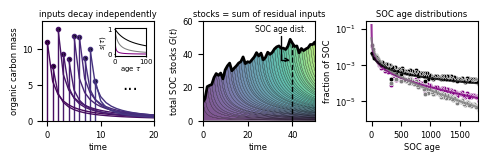

In [5]:
mosaic = 'ABC'
fig, axs = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(4.76, 1.5))
# Most of the plot is about the first model
focal_model = models[0]
model_colors = ['purple', 'grey', 'k']
ages = np.arange(2000)

plt.sca(axs['A'])

# make a color palette with 20 colors
color_order = sns.color_palette("viridis", 60)

# plot the first 10 inputs
for i, (J, color) in enumerate(zip(J_t[:10], color_order[:10])):
    markerline, stemlines, baseline = plt.stem(
        i, J, color)
    markerline.set_markerfacecolor('k')
    markerline.set_markersize(3)
    stemlines.set_linewidth(1)

# g_ts contains the decayed inputs over time
# each row is an input at time t=i
# each column is the amount remaining at time t+age
g_ts = np.zeros((len(J_t), len(ages)+len(J_t) + 10))
for i in range(len(J_t)):
    decay_i = J_t[i]*focal_model.survival_fn(ages)
    g_ts[i, i:i+len(decay_i)] = decay_i

    # plot the first 10 only 
    if i >= 10:
        continue
    plt.plot(ages + i, decay_i, color=color_order[i], lw=1)

plt.xlabel('time')
plt.ylabel('organic carbon mass')
plt.text(15.5, 5, '...', fontsize=12, ha='center', va='center')
plt.xlim(-1, 20)
plt.ylim(0, 14)
plt.title('inputs decay independently')

# Make an inset axis on the top right of A
inset_ax = axs['A'].inset_axes([0.65, 0.65, 0.28, 0.28])
# Plot a some survival function for each model
for my_model, color_name in zip(models, model_colors):
    survival_fn = my_model.survival_fn(ages)
    inset_ax.plot(ages, survival_fn, 
                  color=color_name, lw=0.75)
inset_ax.set_xlim(0, 100)
inset_ax.set_xlabel(r'age $\tau$', fontsize=5, labelpad=0)
inset_ax.set_ylabel(r'$s(\tau)$', fontsize=5, labelpad=0)
inset_ax.tick_params(axis='both', which='major', labelsize=5, length=1, pad=1)

# plot the stocks over time, which is the sum of 
# what remains from prior inputs
plt.sca(axs['B'])

nts = g_ts.shape[1]
njs = g_ts.shape[0]
bottom = np.zeros(nts)
ts = np.arange(nts)
for i in range(njs):
    color = color_order[i % len(color_order)]
    top = bottom + g_ts[i, :]
    plt.fill_between(ts, bottom, top, color=color, alpha=0.7, 
                     edgecolor='k', lw=0.2)
    bottom = top

G_t = np.sum(g_ts, axis=0)
plt.plot(ts, G_t, color='black', lw=2)

# make a vertical dashed line at time = 45
my_t = 40
ymax = G_t[my_t]
plt.plot([my_t, my_t], [0, ymax], color='k', linestyle='--', lw=1)
# annotate the line with a curved arrow
arrowprops=dict(arrowstyle='->', connectionstyle='angle', lw=1)
plt.annotate('SOC age dist.', xy=(my_t, ymax-10), xytext=(my_t - 5, ymax + 7),
             arrowprops=arrowprops, fontsize=5.5, ha='center',
             bbox=dict(boxstyle='square,pad=0.0', edgecolor='none', facecolor='None'))

plt.xlabel('time')
plt.xlim(0, 50)
plt.ylim(0, 60)
plt.ylabel(r'total SOC stocks $G(t)$')
plt.title(r'stocks = sum of residual inputs')

plt.sca(axs['C'])
plt.yscale('log')

for model, color_name in zip(models, model_colors):
    analytical_age_dist = model.age_distribution(ages)
    plt.plot(ages, analytical_age_dist, color=color_name, lw=1.5, alpha=0.8, 
             label=f'$t_min=${model.t_min}, $t_max=${model.t_max}')
    
    # simulated age distribution at time my_t
    my_t = 2000
    simulated_ages = my_t - model.ts
    simulated_stocks = model.g_ts[:, my_t] / np.sum(model.g_ts[:, my_t])
    # remove negative ages and normalize
    SOC_ages = simulated_ages[:my_t]
    stocks = simulated_stocks[:my_t]
    normalized_stocks = stocks / np.sum(stocks)

    # Plot a subset of points to avoid too much overlap
    max_age = min(2000, len(SOC_ages)) # limit to 2000
    idxs = list(np.arange(50)) + list(np.arange(50, max_age, 15))
    plt.scatter(SOC_ages[idxs], normalized_stocks[idxs],
                color=color_name, s=11, edgecolor='w', linewidth=0.4)
    
#plt.legend()
xmin, _ = plt.xlim()
plt.xlim(xmin, 1800)
plt.xticks([0, 500, 1000, 1500])
plt.xlabel('SOC age')
plt.ylabel('fraction of SOC')
plt.title('SOC age distributions')

plt.savefig('../figures/fig1.png', dpi=300, bbox_inches='tight')
plt.show()